In [1]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
^C
User cancelled operation
Archive:  cat-and-dog.zip
replace test_set/test_set/cats/_DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [2]:
!pip install -q kaggle

In [71]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms,datasets
from torchvision.transforms import ToTensor
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
device='mps' if torch.backends.mps.is_available() else 'cpu'

In [5]:
from random import shuffle,seed;seed(10)
class cats_dogs(Dataset):
    def __init__(self,folder):
        cats=glob.glob(folder+'/cats/*.jpg')
        dogs=glob.glob(folder+'/dogs/*.jpg')
        self.fpaths=cats+dogs
        shuffle(self.fpaths)
        self.targets=[fpaths.split('/')[-1].startswith('dog') for fpaths in self.fpaths]
    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self,ix):
        f=self.fpaths[ix]
        target=self.targets[ix]
        im=cv2.cvtColor(cv2.imread(f),cv2.COLOR_BGR2RGB)
        im=cv2.resize(im,(224,224))
        return torch.tensor(im/255).permute(2,0,1).float().to(device),torch.tensor([target]).float().to(device)
    

In [6]:
train_data_dir='/Users/chowdaryadithyasaividivada/Documents/Pytorch_book_practice/cat-and-dog/training_set/training_set'
test_data_dir='/Users/chowdaryadithyasaividivada/Documents/Pytorch_book_practice/cat-and-dog/test_set/test_set'

In [7]:
data=cats_dogs(train_data_dir)

In [8]:
im,label=data[202]

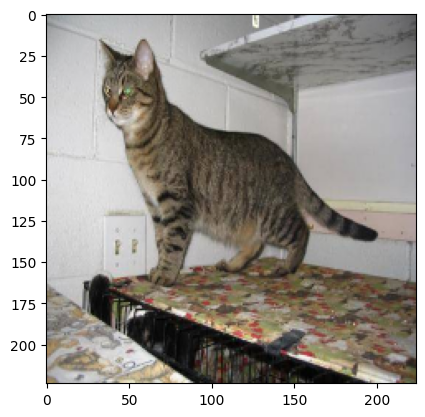

In [9]:
plt.imshow(im.permute(1,2,0).cpu())

In [10]:
data.fpaths

['/Users/chowdaryadithyasaividivada/Documents/Pytorch_book_practice/cat-and-dog/training_set/training_set/dogs/dog.2249.jpg',
 '/Users/chowdaryadithyasaividivada/Documents/Pytorch_book_practice/cat-and-dog/training_set/training_set/cats/cat.3726.jpg',
 '/Users/chowdaryadithyasaividivada/Documents/Pytorch_book_practice/cat-and-dog/training_set/training_set/cats/cat.1522.jpg',
 '/Users/chowdaryadithyasaividivada/Documents/Pytorch_book_practice/cat-and-dog/training_set/training_set/dogs/dog.1246.jpg',
 '/Users/chowdaryadithyasaividivada/Documents/Pytorch_book_practice/cat-and-dog/training_set/training_set/dogs/dog.2161.jpg',
 '/Users/chowdaryadithyasaividivada/Documents/Pytorch_book_practice/cat-and-dog/training_set/training_set/cats/cat.2587.jpg',
 '/Users/chowdaryadithyasaividivada/Documents/Pytorch_book_practice/cat-and-dog/training_set/training_set/cats/cat.2132.jpg',
 '/Users/chowdaryadithyasaividivada/Documents/Pytorch_book_practice/cat-and-dog/training_set/training_set/dogs/dog.449

In [11]:
def conv_layer(ni,no,kernel,strid=1):
    return nn.Sequential(
                            nn.Conv2d(ni,no,kernel_size=kernel,stride=strid),
                            nn.ReLU(),
                            nn.BatchNorm2d(no),
                            nn.MaxPool2d(2)
    )

In [12]:
def get_model():
    model=nn.Sequential(
                            conv_layer(3,64,3),
                            conv_layer(64,512,3),
                            conv_layer(512,512,3),
                            conv_layer(512,512,3),
                            conv_layer(512,512,3),
                            conv_layer(512,512,3),
                            nn.Flatten(),
                            nn.Linear(in_features=512,out_features=1)
    ).to('mps')
    loss_fn=nn.BCEWithLogitsLoss()
    optimizer=torch.optim.Adam(params=model.parameters(),lr=1e-2)
    return model,loss_fn,optimizer
                            

In [13]:
from torchsummary import summary
model,loss_fn,optimizer=get_model()
summary(model,torch.zeros([1,3,224,224]))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [14]:
def get_data():
    train=cats_dogs(train_data_dir)
    trn_dl=DataLoader(train,batch_size=8,shuffle=True,drop_last=True)

    val=cats_dogs(test_data_dir)
    val_dl=DataLoader(val,batch_size=32,shuffle=True,drop_last=True)
    return trn_dl,val_dl
device='mps'

In [15]:
def train_batch(model,x,y,opt,loss_fn):
    model.train()
    x=x.to('mps')
    y=y.to('mps')
    y_pred=model(x)
    loss=loss_fn(y_pred,y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

trainload,testload=get_data()

In [60]:
from tqdm.auto import tqdm

for i in tqdm(range(10)):

    for batch,(x,y) in enumerate(iter(trainload)):
        loss=train_batch(model.to('mps'),x,y,optimizer,loss_fn)
        if(batch%100==0):
            print(loss)

  0%|          | 0/10 [00:00<?, ?it/s]

0.6041184067726135
0.38773590326309204
0.4784879684448242
0.8366636037826538
0.5728049278259277
0.959140419960022
0.7678455114364624
0.2859897017478943


KeyboardInterrupt: 

In [61]:
print(next(model.parameters()).device)  # Should print: mps
print(x.device, y.device)  # Should print: mps mps

mps:0
mps:0 mps:0


In [81]:
inputimage='/Users/chowdaryadithyasaividivada/Downloads/images (6).jpeg'
img=cv2.cvtColor(cv2.imread(inputimage),cv2.COLOR_BGR2RGB)
img=cv2.resize(img,(224,224))
print(img.shape)
finalinp=torch.tensor(img).float().to('mps').permute(2,0,1)
print(finalinp.shape)


(224, 224, 3)
torch.Size([3, 224, 224])


In [82]:
with torch.inference_mode():
    y_pred=model(finalinp.unsqueeze(0))
    final=torch.sigmoid(y_pred)
    print(final)
    if final>0.5:
        print('dog')
    else:
        print('cat')

tensor([[0.2154]], device='mps:0')
cat


In [83]:
torch.save(model.state_dict(),'catdog.pth')